In [210]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ku0s80p_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ku0s80p_
  Resolved https://github.com/tensorflow/docs to commit 51a06aaf26763abe21ec0f2f6d1d08413a31e3e8
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2023.7.13.64986-py3-none-any.whl size=184123 sha256=e343929ef814e17d2fecc9ba116b5df361588fecb4bad08f725f2f257e901bb9
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbk1z7wa/wheels/86/0f/1e/3b62293c8ffd0fd5a49508e6871cdb7554abe9c62afd35ec53
Successfully built tensorflow-docs


In [211]:
# Dependencies
import os
import time
import shutil
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import (
    Input, Dense, BatchNormalization, LeakyReLU,
    Reshape, Conv2DTranspose, Conv2D, Flatten,
    Dropout
)

import PIL
import glob
import imageio
import tensorflow_docs.vis.embed as embed

## **Data Preparation**

**Data Downloading**

In [185]:
dataset, ds_info = tfds.load(
    name="fashion_mnist",
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

In [186]:
dataset

[<_PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>]

In [187]:
# CONSTANTS
NUM_TRAINING_EXAMPLES = tf.data.experimental.cardinality(dataset[0]).numpy()
NUM_CLASSES = ds_info.features['label'].num_classes
CLASS_NAMES = ds_info.features['label'].names
IMG_SIZE = (28, 28)
IMG_SHAPE = (28, 28, 1)
BUFFER_SIZE = 6000
BATCH_SIZE = 128
TF_AUTOTUNE = tf.data.AUTOTUNE
NUM_EXAMPLES_GENERATED = 16
NOISE_DIM = 100
LR = 0.001
EPOCHS = 100
CHECKPOINT_DIR = "training_checkpoints/"
CHECKPOINT_PREFIX = "ckpt"

**Data Preprocessing**

In [188]:
train_dataset = (
    dataset[0]
      .shuffle(BUFFER_SIZE)
      .map(lambda image, label: (tf.image.resize(image, IMG_SIZE)/255.0, label))
      .cache()
      .batch(BATCH_SIZE)
      .prefetch(TF_AUTOTUNE)
)

In [189]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## **Modeling**

**Define Model, Loss, Optimizers**

> Reference Architecture for DCGANs.

<img src="https://www.researchgate.net/publication/332445799/figure/fig2/AS:1086064408174606@1635949341201/The-architecture-of-the-generator-and-the-discriminator-in-the-DCGAN-model.jpg" />

> **Models**

In [190]:
def create_generator_model(noise_dim):
  """
  Create generator model.
  """
  # Input
  input = Input(shape=(noise_dim,))
  x = Dense(units=7*7*256, use_bias=False)(input)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  # Reshape Layer
  x = Reshape(target_shape=(7, 7, 256))(x)

  # Deconvolution Layers
  x = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  # Output
  output = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)


  # Model
  model = Model(inputs=input, outputs=output, name='generator')

  return model

In [191]:
def create_discriminator_model(image_shape):
  """
  Create discriminator model.
  """
  # Input
  input = Input(shape=image_shape)

  # Convolution Layers
  x = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(input)
  x = LeakyReLU()(x)
  x = Dropout(0.3)(x)

  x = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
  x = LeakyReLU()(x)
  x = Dropout(0.3)(x)

  # Flatten
  x = Flatten()(x)

  # Output
  output = Dense(units=1)(x)


  # Model
  model = Model(inputs=input, outputs=output, name='discriminator')

  return model

**Losses**

In [192]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# generator loss
def generator_loss(fake_output):
  """
  Generator Loss.
  """
  gen_loss = cross_entropy(
      y_true=tf.ones_like(fake_output),
      y_pred=fake_output
  )
  return gen_loss


# discriminator loss
def discriminator_loss(real_output, fake_output):
  """
  Discriminator Loss.
  """
  real_loss = cross_entropy(
      y_true=tf.ones_like(real_output),
      y_pred=real_output
  )

  fake_loss = cross_entropy(
      y_true=tf.zeros_like(fake_output),
      y_pred=fake_output
  )

  total_dis_loss = real_loss + fake_loss
  return total_dis_loss

**Optimizers**

In [193]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
dis_optimizer = tf.keras.optimizers.Adam(learning_rate=LR)

In [194]:
# Create Models
generator = create_generator_model(NOISE_DIM)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_18 (Dense)            (None, 12544)             1254400   
                                                                 
 batch_normalization_27 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_45 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_9 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_27 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                              

In [195]:
discriminator = create_discriminator_model(IMG_SHAPE)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_18 (Conv2D)          (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_48 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_49 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_19 (Dropout)        (None, 7, 7, 128)       

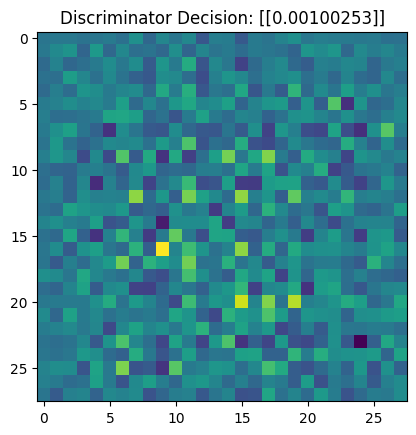

In [196]:
# TEST
random_noise = tf.random.normal(shape=[1, NOISE_DIM])

# Fake image generated by Generator
generated_image = generator(random_noise, training=False)
plt.imshow(generated_image[0, ...])

# Decision by discriminator
decision = discriminator(generated_image)

plt.title(f"Discriminator Decision: {decision}"); # Fake

**Checkpoint**

In [197]:
def save_checkpoint(checkpoint_dir, checkpoint_prefix):
  """Model checkpoint."""
  # Checkpoint object
  checkpoint = tf.train.Checkpoint(
      generator_optimizer=gen_optimizer,
      discriminator_optimizer=dis_optimizer,
      generator=generator,
      discriminator=discriminator
  )
  # Save the checkpoint to the given directory and prefix
  checkpoint.save(file_prefix=checkpoint_prefix)

**Generate and save images**

In [198]:
def generate_and_save_images(model, epoch, test_input, save_dir='generated'):
  """
  Generate images and save to specified folder.
  """
  os.makedirs(save_dir, exist_ok=True)
  predictions = model(test_input, training=False)
  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  save_path = os.path.join(save_dir, f'image_at_epoch_{epoch:04d}.png')
  plt.savefig(save_path)
  plt.show()
  print(f"Generated image saved to {save_path}")

## **Custom Training Loop**

In [199]:
seed = tf.random.normal([NUM_EXAMPLES_GENERATED, NOISE_DIM])

In [200]:
@tf.function
def training_step(images):
  """
  Training step for custom training loop.
  """
  noise = tf.random.normal(shape=[BATCH_SIZE, NOISE_DIM])

  # Forward pass and calculate loss
  with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
    generated_images = generator(noise, training=True)
    real_output = discriminator(images[0], training=True) # only need images and not labels
    fake_output = discriminator(generated_images, training=True)

    # Loss
    gen_loss = generator_loss(fake_output)
    dis_loss = discriminator_loss(real_output, fake_output)

  # Gradient descent
  grads_of_generator = gen_tape.gradient(gen_loss, generator.trainable_weights)
  grads_of_discriminator = dis_tape.gradient(dis_loss, discriminator.trainable_weights)

  # Backward pass
  gen_optimizer.apply_gradients(zip(grads_of_generator, generator.trainable_weights))
  dis_optimizer.apply_gradients(zip(grads_of_discriminator, discriminator.trainable_weights))

In [201]:
def train(dataset, epochs, save_freq=15):
  """
  Training Loop.
  """
  # Loop over epochs
  for epoch in range(epochs):
    print(f"Training for epoch {epoch+1}/{epochs}")
    start = time.time()

    # Loop over batches
    for image_batch in dataset:
      # Training step
      training_step(image_batch)

    # Output
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed) # produce image per epoch for GIF

    # Save model every 10 epochs
    if (epoch+1) % save_freq == 0:
      save_checkpoint(CHECKPOINT_DIR, CHECKPOINT_PREFIX)

    end = time.time()
    total_time = end - start
    print(f"Time for epoch {epoch+1} is {total_time:.3f} sec")

  # generate after final epoch
  generate_and_save_images(generator, epochs, seed)

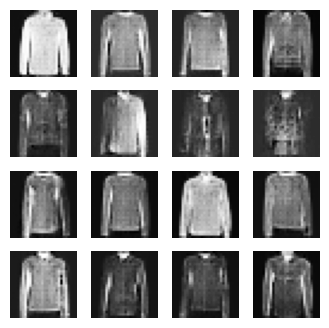

Generated image saved to generated/image_at_epoch_0100.png
Time for epoch 100 is 11.430 sec


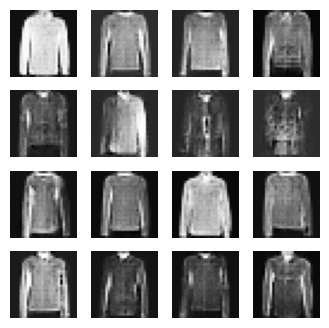

Generated image saved to generated/image_at_epoch_0100.png


In [202]:
train(train_dataset, EPOCHS)

In [205]:
# Display single image at epoch
def display_epoch_image(epoch):
  """
  Display image for given epoch number.
  """
  return PIL.Image.open("generated/image_at_epoch_{:04d}.png".format(epoch))

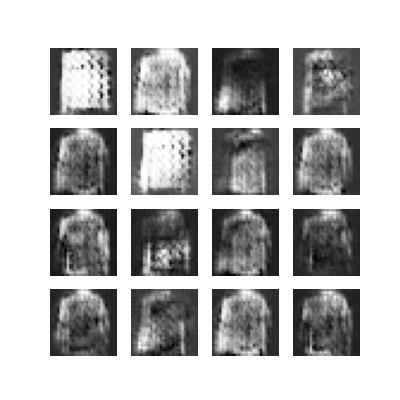

In [206]:
display_epoch_image(10)

In [207]:
def create_animation(image_files, animation_file):
  """
  Create GIF from generated images.
  """
  with imageio.get_writer(animation_file, mode='I') as writer:
    filenames = glob.glob(image_files)
    filenames = sorted(filenames)
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)

## **Show GIF**

In [212]:
image_files_pattern = 'generated/image_at_epoch_*.png'
animation_file = 'fashion-dcgan.gif'

create_animation(image_files_pattern, animation_file)

<ipython-input-207-066fcca57a64>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



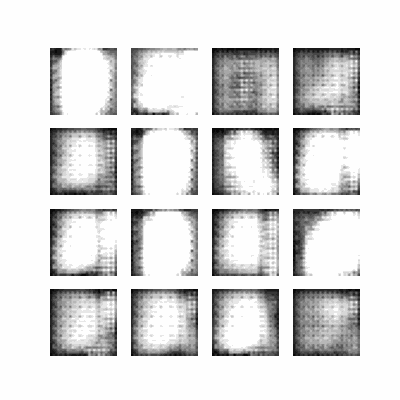

In [214]:
embed.embed_file("/content/fashion-dcgan.gif")